In [1]:
import pandas as pd
import datetime as datetime
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set()

In [2]:
station_path = "../data/interim/dot_traffic_stations_2015.csv"
traffic_path = "../data/interim/dot_traffic_2015.csv"

In [3]:
traffic_df = pd.read_csv(traffic_path)
station_df = pd.read_csv(station_path)

# EDA

Creating some helper functions to clean the data and for feature engineering.

In [4]:
def create_max_volume_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a daily max volume column for EDA purpose by summing up all the traffic_volume columns
    
    Args:
        df (pd.DataFrame): Dataframe to modify
        
    Returns:
        modified_df (pd.DataFrame): DataFrame with new total_volume column
    """
    volume_columns = [column for column in df.columns if column.startswith("traffic_volume")]
    df["total_volume"] = df[volume_columns].sum(axis=1)
    
    return df


def convert_established_year_to_int(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert the year_station_established to int by adding a 2000 to any number between 0 and 15, while adding a
    1900 to any number between 16 and 99. Assumption is based on the dataset being from 2015 ie. it is not possible to have 2016
    
    Args:
        df (pd.DataFrame): Dataframe to modify
        
    Returns:
        modified_df (pd.DataFrame): DataFrame with modified established_year column
    """
    df["year_station_established"] = df["year_station_established"].apply(lambda x: 2000 + x if x <= 15 else 1900 + x)
    
    return df

def create_years_of_operation_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a year of operation column that computes the number of years that the observation station has been in service
    
    Args:
        df (pd.DataFrame): Dataframe to create the year of operation column
        
    Returns:
        new_df (pd.DataFrame): DataFrame with a new year_of_operation column
    """
    df["year_of_data"] = df["year_of_data"] + 2000
    df["year_of_service"] = df["year_of_data"] - df["year_station_established"]
    
    return df

Since we will be doing traffic volume prediction for New York specifically, we can drop the irrelevant stations that are not situated in New York. Based on https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696, the state code for New York is 36

Lets do some EDA on the respective df to see if we can generate any informative insights from them. Since we are trying to predict traffic volume for the New York's rush hour

In [5]:
NEW_YORK_CODE = 36

In [6]:
station_df = station_df[station_df["fips_state_code"] == NEW_YORK_CODE]
traffic_df = traffic_df[traffic_df["fips_state_code"] == NEW_YORK_CODE]

Since all the fips_state_code will be of only one value, we can safely drop this column also

In [7]:
station_df.drop("fips_state_code", inplace=True, axis=1)
traffic_df.drop("fips_state_code", inplace=True, axis=1)

After dropping selectively dropping the irrelevant stations, let's combine the two dataframe into one combined dataframe for the EDA

In [8]:
combined_df = traffic_df.merge(station_df,
                               on=["station_id", "direction_of_travel_name",
                                   "functional_classification_name", "lane_of_travel",
                                   "year_of_data"])

In [9]:
combined_df.describe()

,day_of_data,day_of_week,lane_of_travel,month_of_data,record_type_x,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data,classification_system_for_vehicle_classification,concurrent_route_signing,fips_county_code,latitude,longitude,lrs_location_point,method_of_data_retrieval,method_of_traffic_volume_counting,method_of_vehicle_classification,number_of_lanes_in_direction_indicated,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,sample_type_for_traffic_volume,sample_type_for_vehicle_classification,year_station_discontinued,year_station_established
count,247120.000000,247120.000000,247120.000000,247120.000000,247120.0,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.0,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.0,247120.0,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.000000,247120.0,247120.000000,247120.0,247120.000000
mean,15.736492,4.025320,1.593311,6.273689,3.0,95.959635,68.198106,55.443792,57.844784,81.623074,153.649907,279.197418,375.904726,377.207531,359.621131,370.340175,396.185926,417.040855,423.651530,449.952197,488.763831,509.104172,492.004601,408.740126,331.145557,276.395112,232.251602,186.333263,141.674332,15.0,13.210416,0.285177,60.697212,42.318690,75.313826,21029.347422,2.0,3.0,1.751963,2.192473,2.192473,0.394262,1.225336,2.517303,1.0,0.583988,0.0,26.500643
std,8.800760,1.998778,0.774704,3.359880,0.0,716.281337,729.663125,689.431330,757.305878,744.685426,715.339658,747.289996,665.858965,613.582845,579.375130,543.890345,517.450102,542.603639,619.957995,632.069093,658.738313,685.606553,783.048879,763.558676,745.119509,720.088445,733.671261,719.118930,691.307991,0.0,0.613644,0.855264,34.033523,1.154043,1.828178,21626.098901,0.0,0.0,1.478690,0.925752,0.925752,0.907341,1.237709,1.634108,0.0,0.492897,0.0,35.650821
min,1.000000,1.000000,1.000000,1.000000,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.0,13.000000,0.000000,1.000000,40.526135,72.203335,108.000000,2.0,3.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000
25%,8.000000,2.000000,1.000000,3.000000,3.0,9.000000,5.000000,4.000000,4.000000,8.000000,19.000000,44.000000,75.000000,90.000000,103.000000,114.000000,125.000000,132.000000,134.000000,145.000000,159.000000,161.000000,144.000000,106.000000,77.000000,59.000000,43.000000,28.000000,17.000000,15.0,13.000000,0.000000,29.000000,41.347144,73.789859,3577.000000,2.0,3.0,0.000000,2.000000,2.000000,0.0000

Based on a simple describe function, we can already tell there's some columns that should not be used such as method_of_data_retrieval, method_of_traffic_volume_counting as they only have unique value which will be relatively useless in helping our prediction. Will be noted down and removed later

It will be nice to have a total_volume for a particular day for EDA on a daily level

In [10]:
combined_df = create_max_volume_column(combined_df)

Lets check the common columns to make sure they agree with each other as a sanity check

Based on the basic info here, we will address missing values, and also what columns to keep for modelling before we move on to feature engineering and preprocessing the data to be used for modelling.

Based on the information above, we will definitely drop the shrp_site_identification column as it has 0 (!) non-null values and there's literally nothing for us to work with.

We will also do some sanity check to ensure we merged correctly ie. the number of rows for traffic_df should be exactly the same as combined_df.

In [11]:
len(combined_df) == len(traffic_df)

True

### year_of_station_established

For easier sorting of the data, we will change the year_station_established column to int and also convert them to its full form. ie. 98 -> 1998, 0 -> 2001. We will assume that any number greater 15 is from the 1900s and any number between 0 and 15 is from the 2000s since the dataset is from 2015

In [12]:
combined_df = convert_established_year_to_int(combined_df)
station_df = convert_established_year_to_int(station_df)

D:\Users\DARYL\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


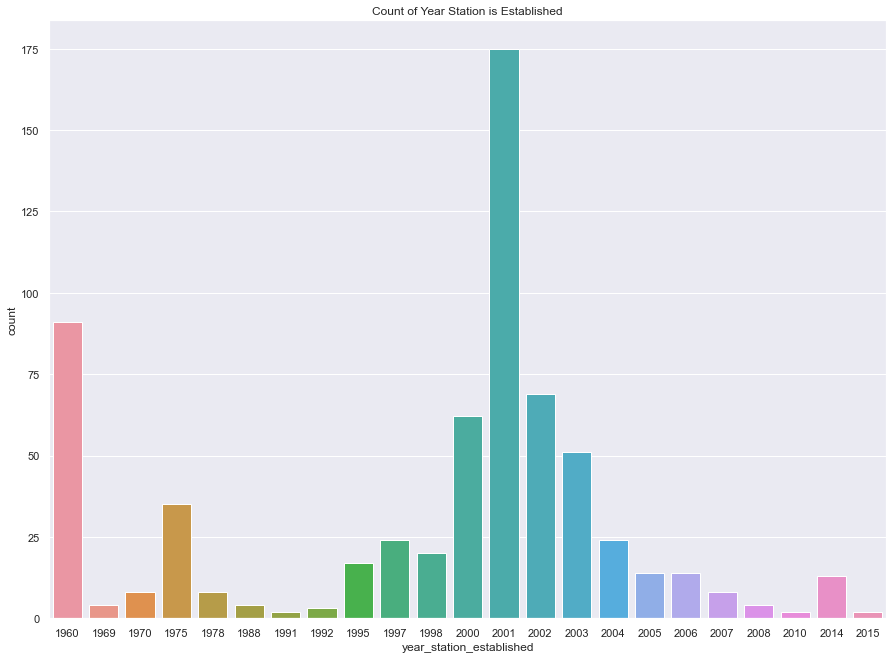

In [13]:
plot_dims = (15, 11)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Count of Year Station is Established")
sns.countplot(station_df["year_station_established"])
plt.show()

Most of the observation stations are relatively new where they are constructed some time during the 2000s. However we have an exceeding number of stations that are built during the 1960s also. 

Since we will be working in time series, it will be useful to convert the date column to a datetime dtype in pandas

In [14]:
combined_df["date"] = pd.to_datetime(combined_df["date"])

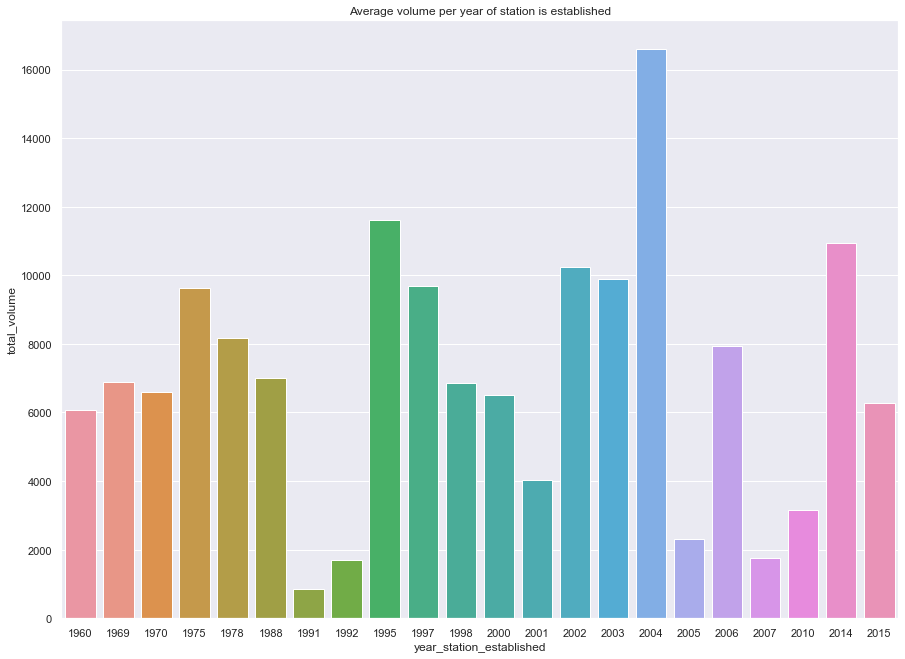

In [43]:
plot_dims = (15, 11)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Average volume per year of station is established")
sns.barplot(x=combined_df.groupby("year_station_established").mean().index, y="total_volume", 
        data=combined_df.groupby("year_station_established").mean())
plt.show()

Not much relationship can be derived from this chart although we can note that the older stations are probably kept as they are typically in high volume places which can be seen that their total volume seem to be slightly above average.

### Day of Week Seasonality Trend

In [16]:
day_groupby = combined_df.groupby("day_of_week").sum()["total_volume"]

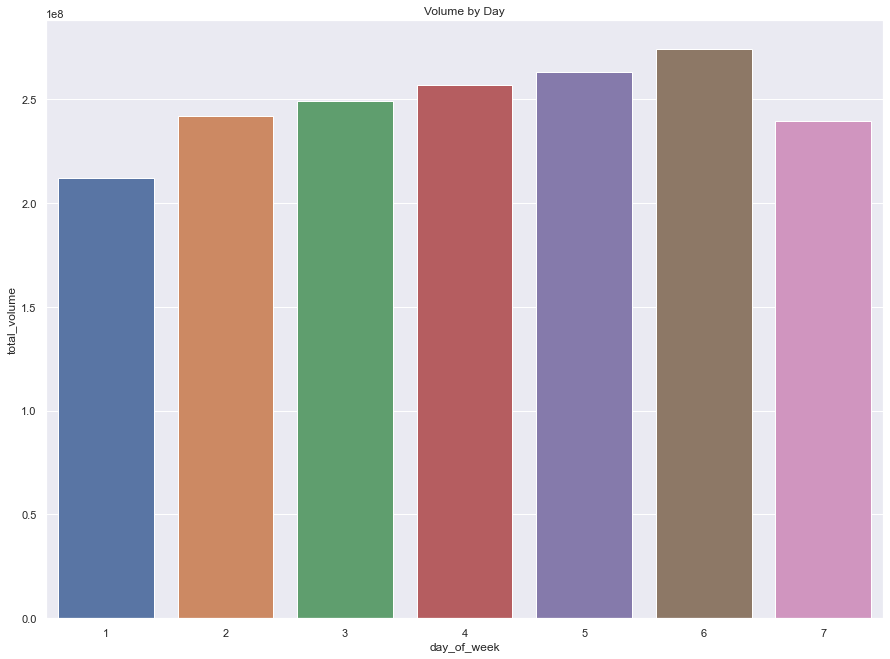

In [17]:
plot_dims = (15, 11)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Volume by Day")
sns.barplot(x=day_groupby.index, y=day_groupby, ax=ax)
plt.show()

We will assume for this dataset that day_7 is Sunday and day_1 is Monday, so on and so forth.

Based on the traffic volume, we can see that other than Monday, all the other week days have the highest volume of traffic. This could be due to people commuting to work.

### Month Seasonality Trend

In [18]:
month_groupby = combined_df.groupby("month_of_data").sum()["total_volume"]

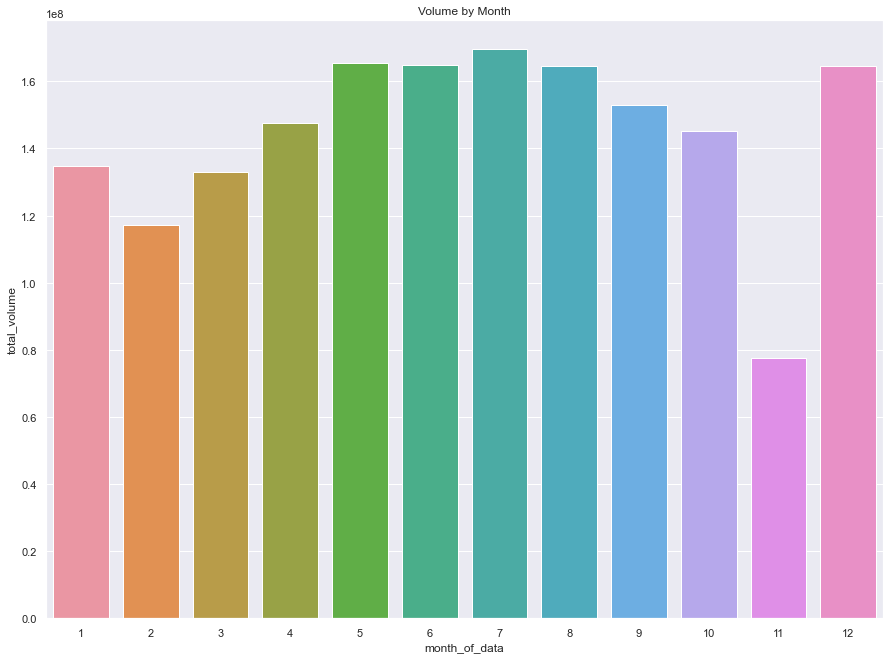

In [19]:
plot_dims = (15, 11)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Volume by Month")
sns.barplot(x=month_groupby.index, y=month_groupby, ax=ax)
plt.show()

The volume across months seems to be fairly consistent however there seem to be a giant spike in traffic volume during the month of December. This could be due to Americans typically travelling across the country to visit their relatives during the festive seasons such as Christmas.

### Hourly Seasonality Trend

In [20]:
volume_columns = [column for column in combined_df.columns if column.startswith("traffic_volume")]
hourly_groupby = combined_df[volume_columns].sum()

In [21]:
# rename column for clarity
for column in volume_columns:
    name = column.split("_")[4]
    hourly_groupby = hourly_groupby.rename(index={column: name})
    

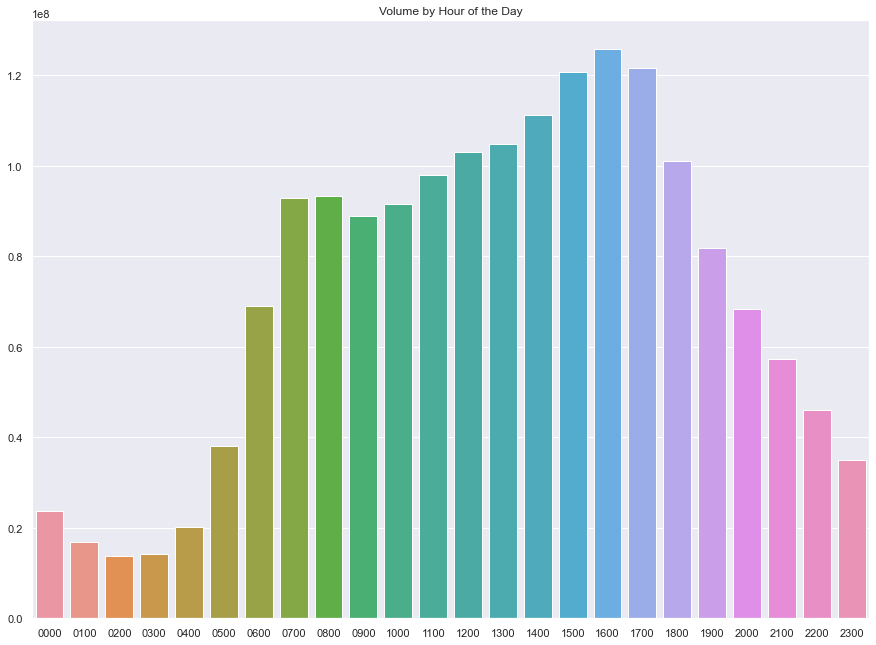

In [22]:
plot_dims = (15, 11)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Volume by Hour of the Day")
sns.barplot(x=hourly_groupby.index, y=hourly_groupby, ax=ax)
plt.show()

Not surprisingly, odd hours such as 10pm to 5am have the lowest traffic volume among all the hours of the day. Volume starts to spike at around 6am as people start commuting to their workplace and delivery fleets start their day. Traffic volume increase continuously throughout the day until around 5pm to 6pm when it starts declining as people start to knock off and commute home where they rest and stop travelling on roads.

Based on Wikipedia, rush hour is typically between 6am to 10am (morning) and 3pm to 7pm (evening) which seems to agree with this plot where traffic volume is typically at its highest.

### Lane of Travel

Lane of travel is in int dtype when it is actually a mapping, converting it back to category for visualisation purposes

In [23]:
combined_df["lane_of_travel"] = combined_df["lane_of_travel"].astype("object")

In [24]:
lane_of_travel_groupby = combined_df.groupby("lane_of_travel").sum()
lane_of_travel_groupby.reset_index(inplace=True)

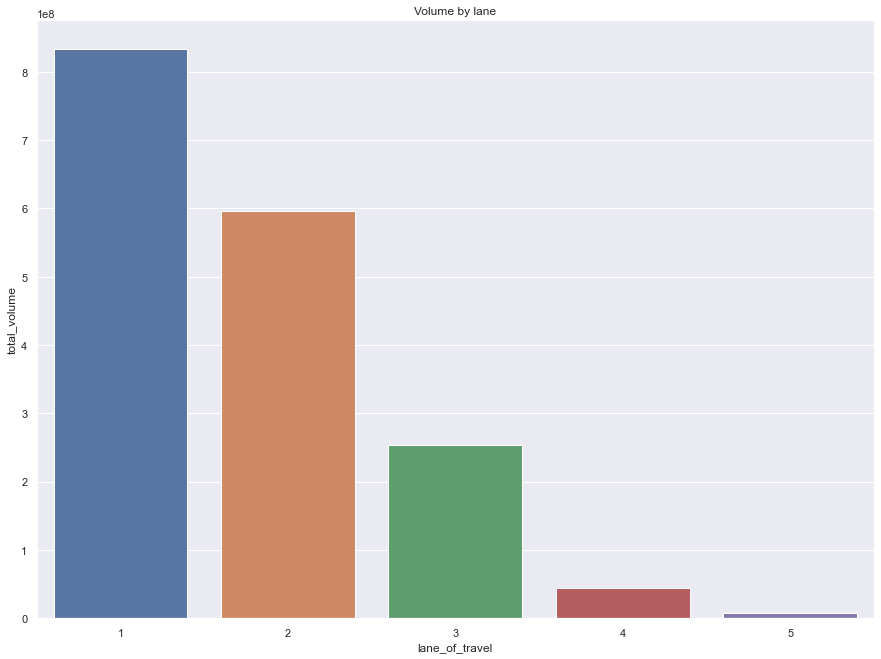

In [25]:
plot_dims = (15, 11)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Volume by lane")
sns.barplot(y="total_volume", x="lane_of_travel", data=lane_of_travel_groupby)
plt.show()

Based on the prior mapping, lane_of_travel value of 1 is the right (outer most lane) while lane 2 to 5 are "Other Lanes".

Intuitively, lane 1 would definitely have the most volume of traffic since all roads would have a minimum of at least 1 lane wheras having 2 to 5 lanes is definitely not a given. Hence this data does make sense as to why the volume of traffic is in chronological order.

### Direction of Travel

In [44]:
direction_of_travel_groupby = combined_df.groupby("direction_of_travel_name").sum()
direction_of_travel_groupby.reset_index(inplace=True)

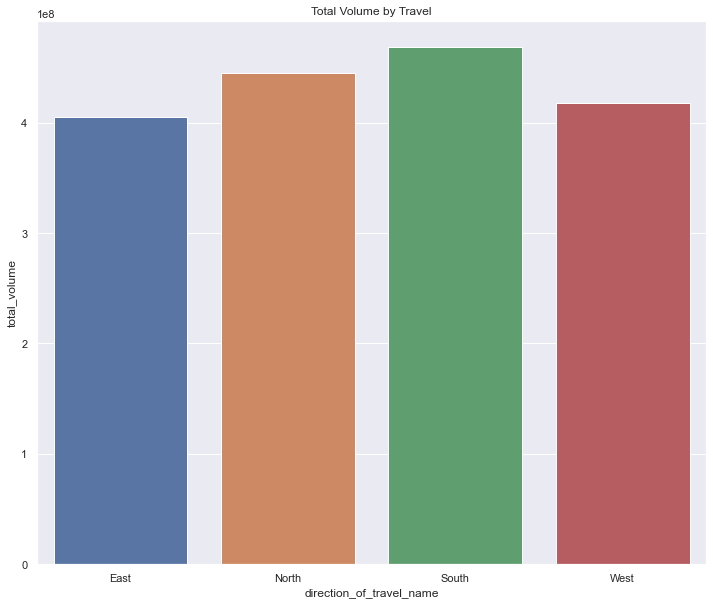

In [52]:
plot_dims = (12, 10)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("Total Volume by Travel")
sns.barplot(x="direction_of_travel_name", y="total_volume", data=direction_of_travel_groupby)
plt.show()

Total traffic volume for the direction of travel is the greatest for the South, which makes sense since New York is situated in Northern US and it most people would be more likely to travel south towards Central America 

### Longitude and Latitude

We will be working with station_df data instead since we only need the station specific information. However, based on my external research, I've noticed some discrepency in the longitude data. Finding longitude between 72.20 and 79.75 brought me to India (Using the current latitude).

After experimenting, it seems like the longitude data should be negative. Will be cleaning up the data in this manner.

In [27]:
station_df["longitude"].min()

72.203335

In [28]:
station_df["longitude"].max()

79.758432

In [29]:
station_df["latitude"].min()

40.526135

In [30]:
station_df["latitude"].max()

44.999666

In [31]:
station_df["longitude"] = station_df["longitude"] * -1
combined_df["longitude"] = station_df["longitude"] * -1

By obtaining the minimum value of both longitude and latitude, we can plot out where each of the station is located in New York City by overlaying a bounding box (similar to object detection in Computer Vision) where we have a matrice of ([min_longitude, max_longitude], [min_latitude, max_latitude]) to encapsulate every single station in our dataset before plotting the stations to ensure we capture all the points.

In [32]:
station_df["longitude"].min()

-79.758432

In [33]:
maps = plt.imread("map.png")

In [34]:
bbox = ((station_df["longitude"].min(), station_df["longitude"].max(),
         station_df["latitude"].min(), station_df["latitude"].max()))

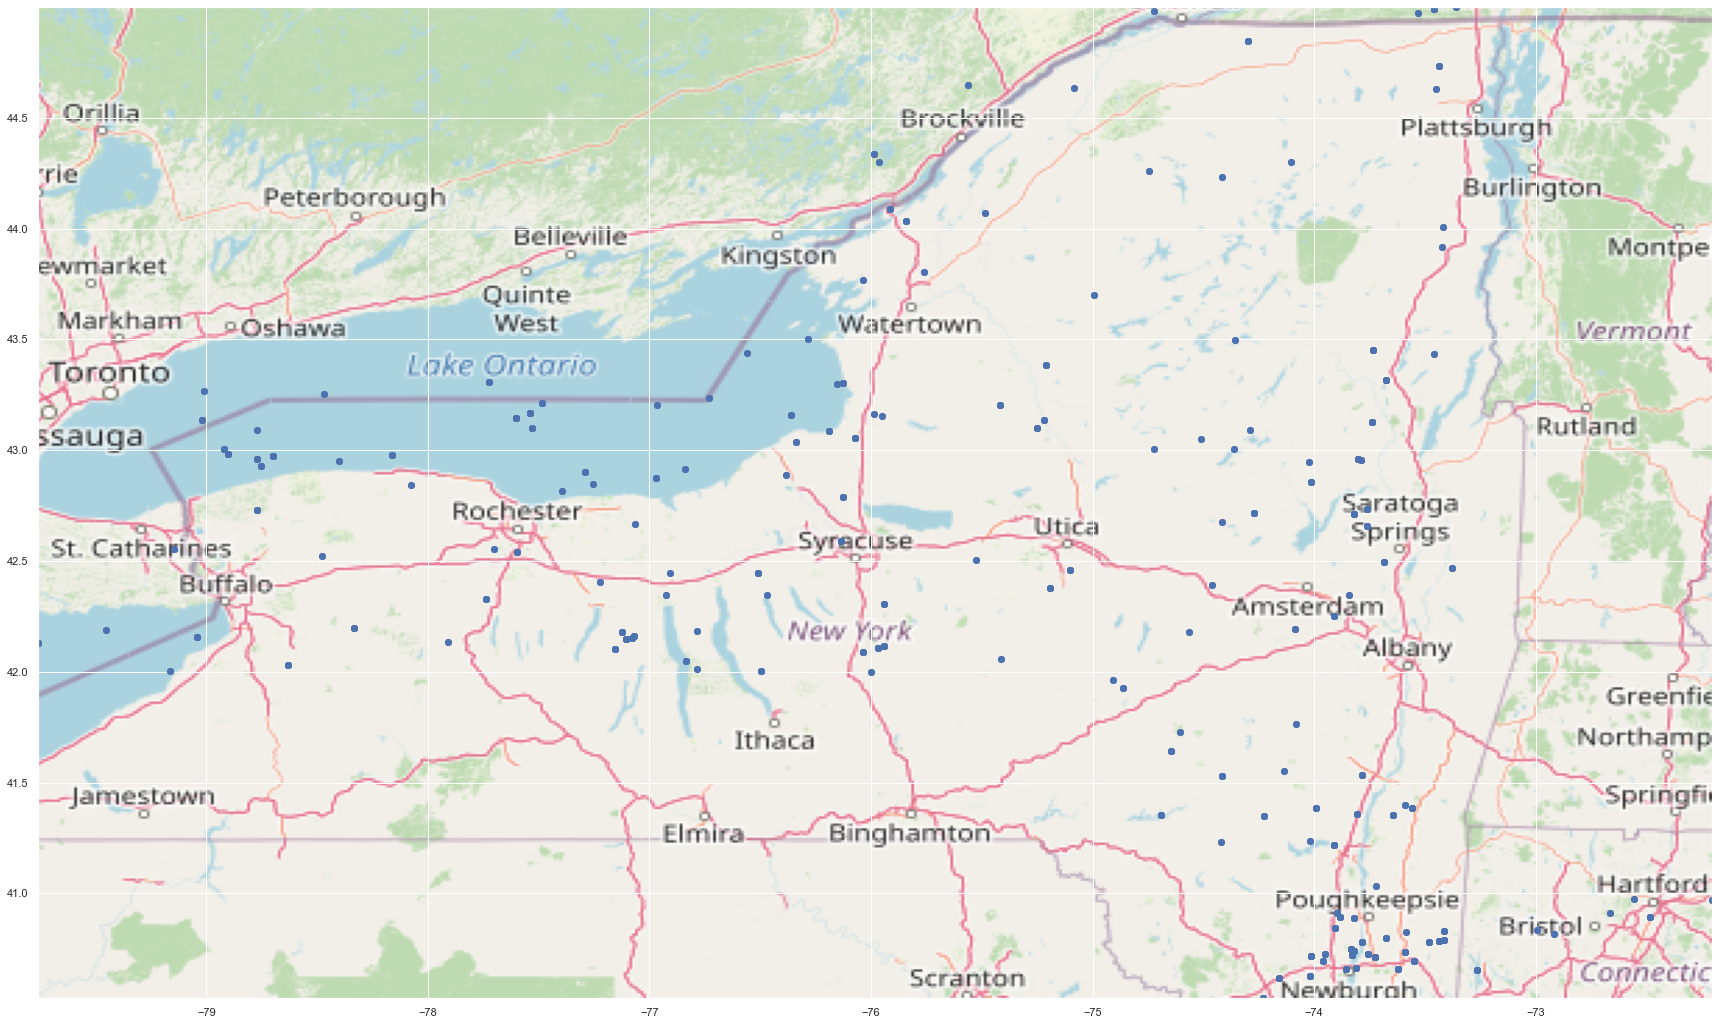

In [35]:
fig, ax = plt.subplots(figsize = (30, 40))
ax.scatter(station_df["longitude"], station_df["latitude"])

ax.imshow(maps, extent=bbox)

After converting longitude to negative, it seems that we are in the vicinity of New York, however some of the observation stations reside in the water (see Lake Ontario). There is a possibility that we did not manipulate the data correctly or that there might be some issues during data collection.

### hpms_sample_identifier & hpms_sample_type

In [63]:
combined_df.loc[(combined_df["hpms_sample_identifier"].isnull()) & (combined_df["hpms_sample_type"] != "N")]

,date,day_of_data,day_of_week,direction_of_travel_name,functional_classification_name,lane_of_travel,month_of_data,record_type_x,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data,algorithm_of_vehicle_classification,calibration_of_weighing_system,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,fips_county_code,hpms_sample_identifier,hpms_sample_type,latitude,longitude,lrs_identification,lrs_location_point,method_of_data_retrieval,method_of_traffic_volume_counting,method_of_truck_weighing_name,method_of_vehicle_classification,national_highway_system,number_of_lanes_in_direction_indicated,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,posted_signed_route_number,previous_station_id,primary_purpose,record_type_y,sample_type_for_traffic_volume,sample_type_for_truck_weight,sample_type_for_vehicle_classification,second_type_of_sensor,shrp_site_identification,station_location,type_of_sensor_name,year_station_discontinued,year_station_established,total_volume,year_of_service


Based on this we can map that the null values for hpms_sample_identifier directly maps to hpms_sample_type. We can choose to keep one of them.

In [65]:
hpms_groupby = combined_df.groupby("hpms_sample_identifier").mean()

In [68]:
hpms_groupby

,day_of_data,day_of_week,month_of_data,record_type_x,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data,classification_system_for_vehicle_classification,concurrent_route_signing,fips_county_code,latitude,longitude,lrs_location_point,method_of_data_retrieval,method_of_traffic_volume_counting,method_of_vehicle_classification,number_of_lanes_in_direction_indicated,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,sample_type_for_traffic_volume,sample_type_for_vehicle_classification,year_station_discontinued,year_station_established,total_volume,year_of_service
hpms_sample_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001000056,15.858763,4.093814,6.420619,3.0,14.647423,8.029897,7.810309,10.750515,19.665979,34.577320,63.916495,92.293814,111.287629,129.094845,147.619588,157.443299,157.492784,154.547423,155.238144,164.923711,165.987629,146.198969,108.915464,82.294845,61.249485,43.217526,28.951546,20.109278,2015.0,13.0,0.0,19.0,44.999666,75.378696,446.0,2.0,3.0,3.0,1.000000,1.000000,1.0,1.000000,2.0,1.0,1.0,0.0,2001.000000,2086.263918,14.000000
000001000356,15.732484,4.029299,6.935032,3.0,7.820382,4.000000,2.588535,4.533758,8.589809,23.593631,64.244586,113.740127,104.766879,116.585987,137.229299,150.363057,153.905732,156.064968,163.606369,173.689172,173.692994,132.564331,87.968153,64.861146,48.033121,36.763057,31.901911,19.788535,2015.0,13.0,3.0,33.0,44.233137,NaN,11473.0,2.0,3.0,3.0,1.000000,1.000000,0.0,1.000000,3.0,1.0,1.0,0.0,1960.000000,1980.895541,55.000000
000001000473,15.580966,4.032670,6.178977,3.0,44.132102,28.782670,24.651989,31.654830,56.586648,113.073864,267.170455,304.242898,281.573864,308.164773,349.482955,368.629261,382.950284,398.968750,462.835227,479.906250,443.629261,386.055398,286.767045,222.538352,170.795455,139.532670,129.928977,94.812500,2015.0,13.0,0.0,115.0,43.435716,NaN,39414.0,2.0,3.0,3.0,1.000000,1.000000,1.0,1.000000,2.0,1.0,1.0,0.0,2001.000000,5776.866477,14.000000
000001001475,15.484882,4.000000,5.220605,3.0,8.640538,5.098544,5.033595,5.645017,12.249720,27.206047,65.041433,83.997760,79.815230,94.515118,114.678611,127.771557,135.169093,130.603583,139.363942,150.075028,156.156775,137.113102,98.657335,73.209406,53.773796,36.690929,27.805151,18.784994,2015.0,13.0,0.0,15.0,42.011750,NaN,1374.0,2.0,3.0,3.0,1.000000,1.000000,0.0,1.000000,3.0,1.0,1.0,0.0,2001.000000,1787.096305,14.000000
000001001709,15.743976,4.033133,6.144578,3.0,11.896084,7.424699,6.355422,7.628012,15.286145,39.975904,65.900602,92.314759,101.677711,122.766566,139.301205,158.762048,169.649096,153.890060,149.115964,156.807229,163.745482,139.236446,108.605422,87.989458,69.298193,46.268072,29.593373,19.993976,2015.0,13.0,3.0,25.0,42.056467,NaN,595.0,2.0,3.0,3.0,1.000000,1.000000,0.0,1.000000,3.0,1.0,1.0,0.0,2001.000000,2063.481928,14.000000
000001004342,15.777108,4.018072,6.147590,3.0,11.444277,7.235693,7.400602,9.442771,18.061747,37.912651,76.388554,111.700301,114.756777,136.1

<AxesSubplot:xlabel='hpms_sample_identifier', ylabel='total_volume'>

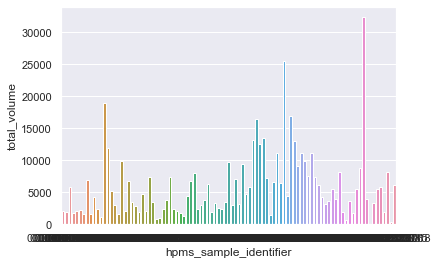

In [67]:
plot_dims = (12, 10)
fig, ax= plt.subplots(figsize=plot_dims)
plt.title("HPMS Sample ")
sns.barplot(x=hpms_groupby.index, y="total_volume", data=hpms_groupby)

Seems like the specific hpms_sample_identifier has an impact on the total volume of the traffic, hence we will keep the hpms_sample_identifier column over the hpms_sample_type_column

In [69]:
combined_df.drop("hpms_sample_type", axis=1, inplace=True)

## Feature Engineering

Some interesting features we can engineer from this dataset could be the total traffic volume in a day. This could be useful when we are trying to determine if there's any seasonality based on months.

We can also engineer a new feature where we determine the number of years that the station has been in operation. We can do this by subtracting the year 2015 with the year where the station is established. We should probably do a sanity check that the year_station_discontinued is 0 and the year_of_data is all 15

### years_of_operation

In [36]:
combined_df["year_station_discontinued"].unique()

array([0], dtype=int64)

All stations should be operational, hence this data makes sense and we can just drop this since it does not offer any new information.

In [37]:
combined_df["year_of_data"].unique()

array([15], dtype=int64)

The data only comprises of 2015 data which is why the year of data column only have 15 inside.

In [38]:
combined_df = create_years_of_operation_column(combined_df)

Created a new column indicating the number of years that the observation station is being used and then dropping the year of data and year_station_discontinued column as we don't need it anymore (one unique value only).

In [39]:
# combined_df.drop(["year_of_data", "year_station_discontinued", "year_station_established"], inplace=True, axis=1)

In [40]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247120 entries, 0 to 247119
Data columns (total 71 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   date                                              247120 non-null  datetime64[ns]
 1   day_of_data                                       247120 non-null  int64         
 2   day_of_week                                       247120 non-null  int64         
 3   direction_of_travel_name                          247120 non-null  object        
 4   functional_classification_name                    247120 non-null  object        
 5   lane_of_travel                                    247120 non-null  object        
 6   month_of_data                                     247120 non-null  int64         
 7   record_type_x                                     247120 non-null  int64         
 8   station_id    

## Preprocessing

Final round of cleaning where we remove any columns with only one unique value as it will not help the model in predicting

In [41]:
for column in combined_df.columns:
    if len(combined_df[column].unique()) == 1:
        combined_df.drop(column, inplace=True, axis=1)

## Summary

Based on the EDA, some of the interesting insights that we can derive are:

1. dsd

and these are some of the features that was engineered:

1. year_of_operation
2. max_volume
3. 

and these are the columns that were dropped:
1. method_of_data_retrieval
2. method_of_traffic_volume_counting
3. year_of_data
4. year_station_discontinued
5. year_station_established
6. record_type

In [53]:
combined_df["posted_route_signing"]

,date,day_of_data,day_of_week,direction_of_travel_name,functional_classification_name,lane_of_travel,month_of_data,record_type_x,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data,algorithm_of_vehicle_classification,calibration_of_weighing_system,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,fips_county_code,hpms_sample_identifier,hpms_sample_type,latitude,longitude,lrs_identification,lrs_location_point,method_of_data_retrieval,method_of_traffic_volume_counting,method_of_truck_weighing_name,method_of_vehicle_classification,national_highway_system,number_of_lanes_in_direction_indicated,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,posted_signed_route_number,previous_station_id,primary_purpose,record_type_y,sample_type_for_traffic_volume,sample_type_for_truck_weight,sample_type_for_vehicle_classification,second_type_of_sensor,shrp_site_identification,station_location,type_of_sensor_name,year_station_discontinued,year_station_established,total_volume,year_of_service
0,2015-10-27,27,3,East,Urban: Minor Arterial,1,10,3,009582,13,3,8,3,17,47,95,158,151,151,141,184,193,219,217,238,278,250,154,130,84,56,21,14,2015,F,NaN,13,0,NaN,95,NaN,N,42.677500,NaN,000010007903,29935.0,2,3,0,3,N,1,1,0,1,3,00000145,NaN,P,S,1,NaN,1,P,NaN,0.1 MILE S OF RT 88I,Inductance loop,0,2001,2825,14
1,2015-09-18,18,6,East,Urban: Minor Arterial,1,9,3,009582,12,5,9,8,7,40,90,156,170,165,194,233,240,267,263,276,305,307,206,176,107,94,61,35,2015,F,NaN,13,0,NaN,95,NaN,N,42.677500,NaN,000010007903,29935.0,2,3,0,3,N,1,1,0,1,3,00000145,NaN,P,S,1,NaN,1,P,NaN,0.1 MILE S OF RT 88I,Inductance loop,0,2001,3426,14
2,2015-10-21,21,4,East,Urban: Minor Arterial,1,10,3,009582,6,2,8,6,10,56,100,170,175,130,179,188,197,181,242,229,305,233,178,96,103,66,36,16,2015,F,NaN,13,0,NaN,95,NaN,N,42.677500,NaN,000010007903,29935.0,2,3,0,3,N,1,1,0,1,3,00000145,NaN,P,S,1,NaN,1,P,NaN,0.1 MILE S OF RT 88I,Inductance loop,0,2001,2912,14
3,2015-01-01,1,5,East,Urban: Minor Arterial,1,1,3,009582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2015,F,NaN,13,0,NaN,95,NaN,N,42.677500,NaN,000010007903,29935.0,2,3,0,3,N,1,1,0,1,3,00000145,NaN,P,S,1,NaN,1,P,NaN,0.1 MILE S OF RT 88I,Inductance loop,0,2001,0,14
4,2015-04-01,1,4,East,Urban: Minor Arterial,1,4,3,009582,8,6,6,7,10,20,68,129,172,166,167,181,207,203,210,246,271,270,172,112,92,80,46,16,2015,F,NaN,13,0,NaN,95,NaN,N,42.677500,NaN,000010007903,29935.0,2,3,0,3,N,1,1,0,1,3,00000145,NaN,P,S,1,NaN,1,P,NaN,0.1 MILE S OF RT 88I,Inductance loop,0,2001,2865,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247115,2015-12-16,16,4,East,Urban: Principal Arterial - Interstate,2,12,3,008382,17,27,34,

In [60]:
combined_df["hpms_sample_identifier"].unique()

array([nan, '000002555510', '000003002917', '000003966560',
       '000001015043', '000003966520', '000008000018', '000003007891',
       '000003004181', '000001555100', '000001007278', '000005931002',
       '000001014694', '000003003352', '000003003088', '000003004698',
       '000004897601', '000003966620', '000001000056', '000002000705',
       '000006939015', '000003020790', '000003966510', '000003933690',
       '000006930017', '000006892601', '000002002463', '000003007365',
       '000002001615', '000006934008', '000001014671', '000002001296',
       '000003966640', '000001014848', '000003934270', '000001555020',
       '000001555130', '000002002469', '000003966550', '000001001475',
       '000001555210', '000004899601', '000001555090', '000006908701',
       '000003966530', '000001005637', '000006933007', '000001004342',
       '000003966660', '000005919702', '000001018608', '000003005765',
       '000003001705', '000001021964', '000002000550', '000001555150',
       '000003000

In [62]:
combined_df.loc[(combined_df["hpms_sample_identifier"].isnull()) & (combined_df["hpms_sample_type"] != "N")]

,date,day_of_data,day_of_week,direction_of_travel_name,functional_classification_name,lane_of_travel,month_of_data,record_type_x,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data,algorithm_of_vehicle_classification,calibration_of_weighing_system,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,fips_county_code,hpms_sample_identifier,hpms_sample_type,latitude,longitude,lrs_identification,lrs_location_point,method_of_data_retrieval,method_of_traffic_volume_counting,method_of_truck_weighing_name,method_of_vehicle_classification,national_highway_system,number_of_lanes_in_direction_indicated,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,posted_signed_route_number,previous_station_id,primary_purpose,record_type_y,sample_type_for_traffic_volume,sample_type_for_truck_weight,sample_type_for_vehicle_classification,second_type_of_sensor,shrp_site_identification,station_location,type_of_sensor_name,year_station_discontinued,year_station_established,total_volume,year_of_service
